# **Analyzing the most effective marketing channels and campaigns for Shopee**

Business objective: Identify the most effective marketing channels and campaigns to optimize marketing spend.


**Question 1 : Evaluate the ROI of different marketing channels**

1. **Business goal**: Determine which channels offer the highest ROI and engagement, allowing Shopee to optimize the allocation of their marketing budget.

Identify underperforming channels and redirect marketing budgets towards those yielding higher ROI to enhance cost efficiency.

2. **Key Metrics:**


*   Total revenue: Indicates effectiveness of the marketing channel in driving sales
*   ROI (Return on Investment): Measures cost efficiency of each marketing channel
*   Conversion rate, Click-through Rate (CTR), Bounce rate: Provide insights into customer engagement by channel
*   Cost Per Sale (CPS) & Average Order Value (AOV)




**Question 2 : Analyze the impact of various promotional campaigns on sales**

1. **Business goal:**

Determine which promotional campaigns drive the most sales and provide data-driven insights to Shopee regarding promotional planning.

2. **Key Metrics**

*   Total sales : Indicates impact of various campaigns on sales
*   Average Order Value (AOV) : Assess the revenue generated per order

In [55]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import plotly.express as px
import math

In [56]:
# Read in the datsets
marketing_df = pd.read_csv('../Cleaned_Datasets/synthetic_marketing_data.csv')
campaign_df = pd.read_csv('../Cleaned_Datasets/synthetic_campaign_data.csv')
sales_df = pd.read_csv('../Cleaned_Datasets/shopee_sales_df.csv')

# Data cleaning to ensure consistency

In [ ]:
print(marketing_df.head())
print("\n")
print(campaign_df.head())
print("\n")
print(sales_df.head())

         date  channel_name  channel_expenditure  channel_visitors  \
0  2019-06-07       Website               165.48             444.0   
1  2019-12-15        In-App               201.15             736.0   
2  2019-11-06  Social Media               157.74             999.0   
3  2019-09-18        In-App               200.18             732.0   
4  2019-03-13        In-App               180.24             659.0   

   channel_sales  conversion_rate  average_order_value  total_revenue  \
0           14.0         3.153153            16.701049         233.81   
1           30.0         4.076087            19.295899         578.88   
2           40.0         4.004004            11.439214         457.57   
3           29.0         3.961749            16.086238         466.50   
4           26.0         3.945372            16.697335         434.13   

   click_through_rate  bounce_rate        day  
0            0.009033    62.637806     Friday  
1            0.008315    55.581256     Sunda

In [ ]:
print(marketing_df.dtypes)
# We clean the dataset by converting the click_through_rate to percentage format for easier analysis
marketing_df['click_through_rate'] = marketing_df['click_through_rate'] * 100
marketing_df['date'] = pd.to_datetime(marketing_df['date'])
marketing_df.head()

# Convert channel visitors and sales to integer
marketing_df['channel_visitors'] = marketing_df['channel_visitors'].astype(int)
marketing_df['channel_sales'] = marketing_df['channel_sales'].astype(int)
marketing_df.head()

print(campaign_df.dtypes)
# Convert dates to datetime
campaign_df['start_date'] = pd.to_datetime(campaign_df['start_date'])
campaign_df['end_date'] = pd.to_datetime(campaign_df['end_date'])
campaign_df.head()

print(sales_df.dtypes)
sales_df['order_time'] = pd.to_datetime(sales_df['order_time'])
print(sales_df.isnull().sum())
sales_df.head()

date                    object
channel_name            object
channel_expenditure    float64
channel_visitors       float64
channel_sales          float64
conversion_rate        float64
average_order_value    float64
total_revenue          float64
click_through_rate     float64
bounce_rate            float64
day                     object
dtype: object
campaign_id                     int64
campaign_type                  object
campaign_cost                   int64
session_id                      int64
start_date                     object
end_date                       object
marketing_channel              object
promotional_discount_type      object
promotional_discount_value    float64
is_click                        int64
customer_id                     int64
target_audience                object
dtype: object
order_id                       int64
product_id                     int64
session_id                     int64
is_campaign                    int64
campaign                   

,order_id,product_id,session_id,is_campaign,campaign,main_category,price,total_sold,title,Stock,customer_id,promotional_discount_type,price_range,order_time,discount
0,6523388,11047,256011,1,Mega Sales,Health & Beauty,3.643520,662.0,READY STOCK ! NEW AS BASIC GEL POLISH 新包装美甲多功能...,158,105910,Percentage,Low,2019-02-02,0
1,6650634,16682,765529,1,Livestream Exclusive,Mobile & Accessories,6.228240,173.0,🚚🇲🇾Land Rover W2019/R1 13800mAh Dual Flash/W20...,342,45999,Fixed Amount,Low,2019-12-03,2
2,4404572,18997,890156,1,Seasonal Sales,Mobile & Accessories,71.310235,25.0,Marshall Major 2 Bluetooth Headphones Wireless...,10,53473,Fixed Amount,Mid,2019-04-04,45
3,2334489,900,271656,1,Bundle promotions,Women Clothes,30.144682,3.0,Scuba Diving Suit 1.5MM Wetsuit for Men Neopre...,2247,34849,Percentage,Mid-Low,2019-02-02,7
4,9624682,266,98735,1,Next Day Delivery,Women Clothes,8.408124,916.0,"comfortLOVA STYLE SAFWAA SUIT, MUSLIMAH SUIT, ...",5566,119010,Percentage,Low,2019-06-06,8


# **Question 1 : Evaluate the ROI of different marketing channels**

# Step 1 : Conduct EDA using SQL

We want to conduct simple Exploratory Data Analysis to get a grasp of key patterns in our dataset. We can then use the queries for further analysis and visualization.

1. We query on the ROI of each marketing channel to determine ROI in terms of cost effectiveness
2. We query on the total visitors and sales generated from each marketing channel to derive visitor-to-sales ratio to determine the effectiveness of each marketing channel in generating sales
3. We query on the engagement rates, bounce rates, and CTR to determine engagement of each marketing channel


In [ ]:
# We create an SQL database to use SQL for EDA

conn = sqlite3.connect('marketing_analysis.db')
cursor = conn.cursor()

# Save the DataFrame to an SQL table
marketing_df.to_sql('marketing_data', conn, if_exists='replace', index=False)

# 1st query to calculate ROI based on channel expenditure and revenue

first_query = """
SELECT
    channel_name,
    SUM(channel_expenditure) AS total_expenditure,
    SUM(total_revenue) AS total_revenue,
    (SUM(total_revenue) - SUM(channel_expenditure)) / SUM(channel_expenditure) * 100 AS ROI
FROM
    marketing_data
GROUP BY
    channel_name
ORDER BY
    ROI DESC;
"""

# Execute the query and load results into a dataframe
roi_results = pd.read_sql_query(first_query, conn)
print('ROI based on channel expenditure and revenue')
print(roi_results)
print("\n")

# 2nd query on analysis of visitors and sales

second_query = """
SELECT
    channel_name,
    SUM(channel_visitors) AS total_visitors,
    SUM(channel_sales) AS total_sales,
    COALESCE(SUM(channel_sales), 0) * 1.0 / NULLIF(SUM(channel_visitors), 0) *100 AS visitor_to_sales_rate
FROM
    marketing_data
GROUP BY
    channel_name
ORDER BY
    total_sales DESC;
"""

visitor_sales_results = pd.read_sql_query(second_query, conn)
print('Visitors and sales')
print(visitor_sales_results)
print("\n")

# 3rd query regariding the engagement metrics
third_query = """
SELECT
    channel_name,
    AVG(conversion_rate) AS avg_conversion_rate,
    AVG(bounce_rate) AS avg_bounce_rate,
    AVG(click_through_rate) AS avg_ctr
FROM
    marketing_data
GROUP BY
    channel_name
ORDER BY
    avg_conversion_rate DESC;

"""

engagement_results = pd.read_sql_query(third_query, conn)
print('Average engagement rates')
print(engagement_results)
print("\n")

ROI based on channel expenditure and revenue
   channel_name  total_expenditure  total_revenue         ROI
0           KOL         4002149.29    15598046.67  289.741750
1  Social Media         4404385.90    14527320.96  229.837605
2        In-App         4797890.87    11267709.80  134.847146
3         Email         2398588.91     3220570.32   34.269374
4       Website         3400667.36     4407217.27   29.598599
5           SMS         1000691.17     1201354.81   20.052504


Visitors and sales
   channel_name  total_visitors  total_sales  visitor_to_sales_rate
0  Social Media        27881073      1117139               4.006801
1        In-App        17546908       705135               4.018571
2           KOL        10212568       694481               6.800258
3       Website         9114758       286424               3.142420
4         Email         5550598       175764               3.166578
5           SMS         1644373        50179               3.051558


Average engagement rat

# Key insights from EDA

1.   KOL (290%) and Social Media (230%) have the highest ROI, indicating they are the most effective channels in generating revenue relative to their costs.

2. Social Media attracts the highest number of visitors but has a lower conversion rate (4%) compared to KOL (6.8%).

3. SMS has the lowest total visitors and the lowest visitors to sales rate, indicating the inefficency of SMS as a marketing channel.

4. KOL has the highest average conversion rate (6.8%) and the 2nd lowest bounce rate (40%), indicating relatively high engagement.
Website, Social Media and In-App shows higher bounce rates, which may suggest that the content is not resonating well with recipients.


We will proceed with further analysis and visualizations to analyse and explain the patterns observed.


# Step 2 : Analysis of data and relevant visualizations

In [ ]:
# Calculate total metrics per channel
channel_summary = marketing_df.groupby('channel_name').agg({
    'channel_expenditure': 'sum',
    'total_revenue': 'sum',
    'channel_visitors': 'sum',
    'channel_sales': 'sum',
    'average_order_value' : 'mean'
}).reset_index()

# Calculate ROI, cost per visitor, cost per sale
channel_summary['ROI'] = ((channel_summary['total_revenue'] - channel_summary['channel_expenditure']) /
                          channel_summary['channel_expenditure']) * 100
channel_summary['cost_per_visitor'] = channel_summary['channel_expenditure'] / channel_summary['channel_visitors']
channel_summary['cost_per_sale'] = channel_summary['channel_expenditure'] / channel_summary['channel_sales']

# Calculate mean engagement and conversion metrics by channel
engagement_metrics = marketing_df.groupby('channel_name').agg({
    'conversion_rate': 'mean',
    'click_through_rate': 'mean',
    'bounce_rate': 'mean'
}).reset_index()

# Merge results into one summary df
channel_summary = pd.merge(channel_summary, engagement_metrics, on='channel_name')
channel_summary

,channel_name,channel_expenditure,total_revenue,channel_visitors,channel_sales,average_order_value,ROI,cost_per_visitor,cost_per_sale,conversion_rate,click_through_rate,bounce_rate
0,Email,2398588.91,3220570.32,5550598,175764,16.455213,34.269374,0.432132,13.646645,3.166539,2.496993,34.950391
1,In-App,4797890.87,11267709.80,17546908,705135,15.979292,134.847146,0.273432,6.804216,4.018352,1.001350,54.995901
2,KOL,4002149.29,15598046.67,10212568,694481,22.458139,289.741750,0.391885,5.762792,6.800264,3.007924,40.053391
3,SMS,1000691.17,1201354.81,1644373,50179,8.010440,20.052504,0.608555,19.942430,3.053171,1.501014,45.011244
4,Social Media,4404385.90,14527320.96,27881073,1117139,13.002880,229.837605,0.157970,3.942559,4.006832,2.492693,54.994028
5,Website,3400667.36,4407217.27,9114758,286424,13.962538,29.598599,0.373095,11.872844,3.142332,0.750766,59.980053


## 2a : Evaluating Cost Per Visitor and Cost Per Sale


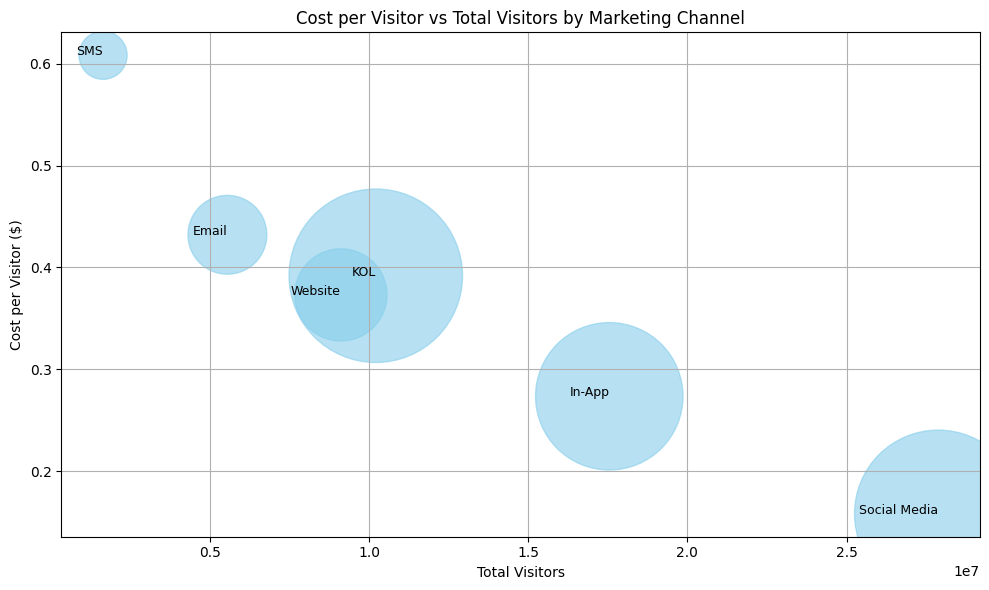

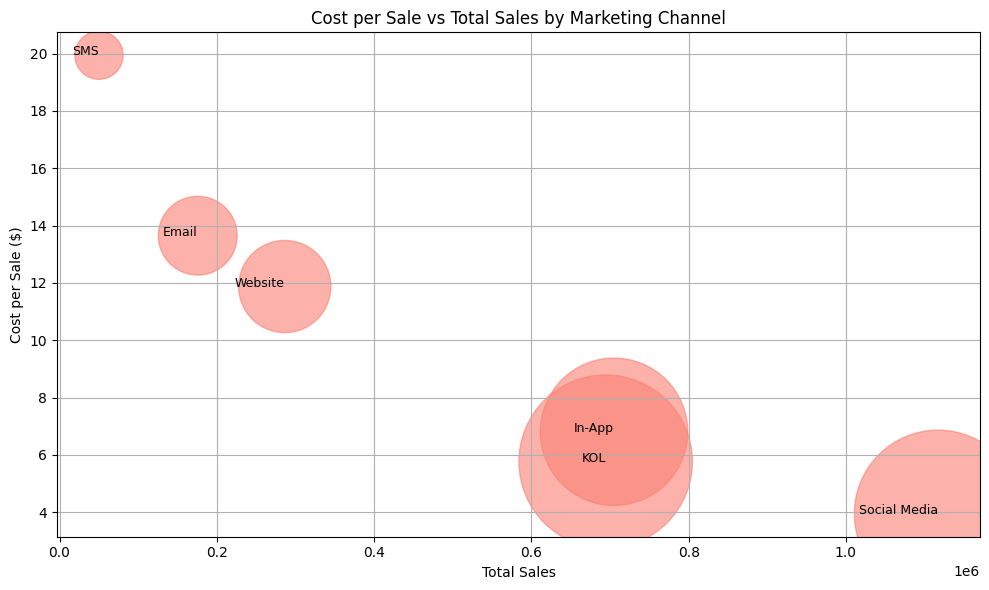

In [ ]:
# Scatter Plot for CPV vs Total Visitors with bubble size based on revenue
plt.figure(figsize=(10, 6))
plt.scatter(channel_summary['channel_visitors'], channel_summary['cost_per_visitor'],
            s=channel_summary['total_revenue']/1000,
            alpha=0.6, color='skyblue')

# Add channel labels
for i, txt in enumerate(channel_summary['channel_name']):
    plt.annotate(txt, (channel_summary['channel_visitors'][i], channel_summary['cost_per_visitor'][i]), fontsize=9, ha='right')

plt.title("Cost per Visitor vs Total Visitors by Marketing Channel")
plt.xlabel("Total Visitors")
plt.ylabel("Cost per Visitor ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot for CPS vs Total Sales with bubble size based on channel revenue
plt.figure(figsize=(10, 6))
plt.scatter(channel_summary['channel_sales'], channel_summary['cost_per_sale'],
            s=channel_summary['total_revenue']/1000,
            alpha=0.6, color='salmon')

# Add channel labels
for i, txt in enumerate(channel_summary['channel_name']):
    plt.annotate(txt, (channel_summary['channel_sales'][i], channel_summary['cost_per_sale'][i]), fontsize=9, ha='right')

plt.title("Cost per Sale vs Total Sales by Marketing Channel")
plt.xlabel("Total Sales")
plt.ylabel("Cost per Sale ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Insights from visualizations

Cost per Visitor vs. Total Visitors (With bubble size indicated revenue generated from channel)


*   Social Media : Highly efficient with the lowest CPV and highest visitor volume, making it highly cost-effective in generating traffic. The large bubble size also indicates the high revenue that Social Media generates.
*   In-App : Moderate CPV with high number of visitors. The large bubble size shows that In-App channel is still able to generate high revenue.
*   KOL, Website, Email : These channels show a middle ground with moderate CPV and visitor counts. But KOL is the channel that drives the most revenue despite that.
*   SMS : Lowest efficiency with the highest CPV but lowest visitor volume, making it the least cost-effective channel for visitor generation. This makes SMS marketing less ideal in generating large scale traffic unless it is used in highly targeted campaigns where the high CPV can be rationalised.


Cost per Sale vs. Total Sales (With bubble size indicated revenue generated from channel)


*   Social Media : Highest efficiency with the lowest CPS and high sales volume, making it the most cost-effective in generating conversions. Coupled with the high revenue generated, Social Media would yield a high ROI.
*   In-App, KOL : Moderate CPS with good sales volume, with a balanced cost-to-sale ratio, making them relatively effective for conversions.
*   Email, Website : Conversions are more expensive through these channels, with total revenue lacking behind of Social Media, In-App and KOL.
*   SMS : Lowest efficiency with high CPS and low total sales, indicating that conversions via SMS are costly. SMS also contributes to the least total revenue.


**Overall Insights**

Social Media is the most efficient in both metrics, and should definitely be considered for scaling efforts in its marketing for optimized returns.

SMS is the least efficient in both metrics, hence scaling down on its marketing budget or using it for more niche audiences or specific high-impact campaigns can be considered.

Optimization Opportunities: Email and Website could become more effective by targeting optimizations in either CPV (for traffic generation) or CPS (for conversions), potentially through focused campaign types like retargeting or loyalty programs.



---

For further analysis on CPS, we can analyse CPS as a percentage of AOV.

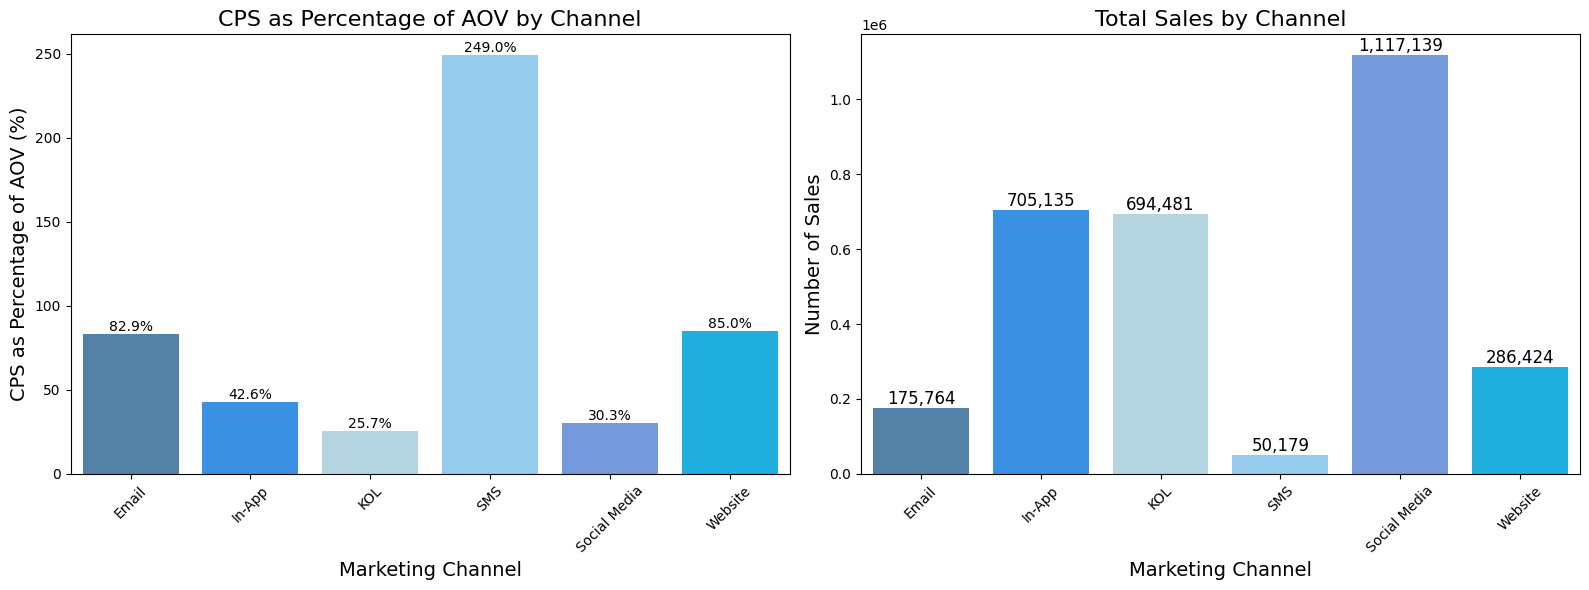

In [ ]:
# Calculate CPS as a percentage of AOV
channel_summary['CPS_as_percentage_of_AOV'] = (channel_summary['cost_per_sale'] / channel_summary['average_order_value']) * 100

# Define consistent colors for each channel
channel_colors = {
    'Email': 'steelblue',
    'Social Media': 'cornflowerblue',
    'In-App': 'dodgerblue',
    'Website': 'deepskyblue',
    'SMS': 'lightskyblue',
    'KOL': 'lightblue'
}

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Bar plot for CPS as Percentage of AOV by Channel
sns.barplot(data=channel_summary, x='channel_name', y='CPS_as_percentage_of_AOV', palette=channel_colors, ax=axes[0], hue = 'channel_name')
axes[0].set_title("CPS as Percentage of AOV by Channel", fontsize=16)
axes[0].set_xlabel("Marketing Channel", fontsize=14)
axes[0].set_ylabel("CPS as Percentage of AOV (%)", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Annotate bars with percentage values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.1f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', color='black', fontsize=10)

# Bar plot for Total Sales by Channel
sns.barplot(data=channel_summary, x='channel_name', y='channel_sales', palette=channel_colors, ax=axes[1], hue = 'channel_name')
axes[1].set_title("Total Sales by Channel", fontsize=16)
axes[1].set_xlabel("Marketing Channel", fontsize=14)
axes[1].set_ylabel("Number of Sales", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Annotate bars with total sales values
for p in axes[1].patches:
    value = int(round(p.get_height()))
    formatted_value = f'{value:,}'
    axes[1].annotate(formatted_value,
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', color='black', fontsize=12)

# Set the y-axis formatter to show normal numbers for the total sales plot
axes[1].yaxis.set_major_formatter(ScalarFormatter())

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Insights from visualizations

KOL, Social Media and In-App have relatively lower Cost-Per-Sale as a percentage of AOV, indicating that these channels are more effective in converting visitors to sales and generating more revenue without overspending, which in turn will lead to a higher ROI.

  However, the percentage range for those channels are around 25% to 42%, which is still relatively high, indicating that cost-effectiveness might be limited. Nonetheless, we can see that those channels brings the highest total sales, indicating that the ROI of KOL, Social Media and In-App channels are among the highest.

  SMS's percentage is way above 100%, which indicates that it is extremely cost-ineffective in driving orders of high value, in turn likely to lead to low ROI. Furthermore, SMS drives the lowest total sales, which in combination leads to poor ROI.


## 2b : Evaluating the Conversion Rate, Bounce Rate, Click Through Rate

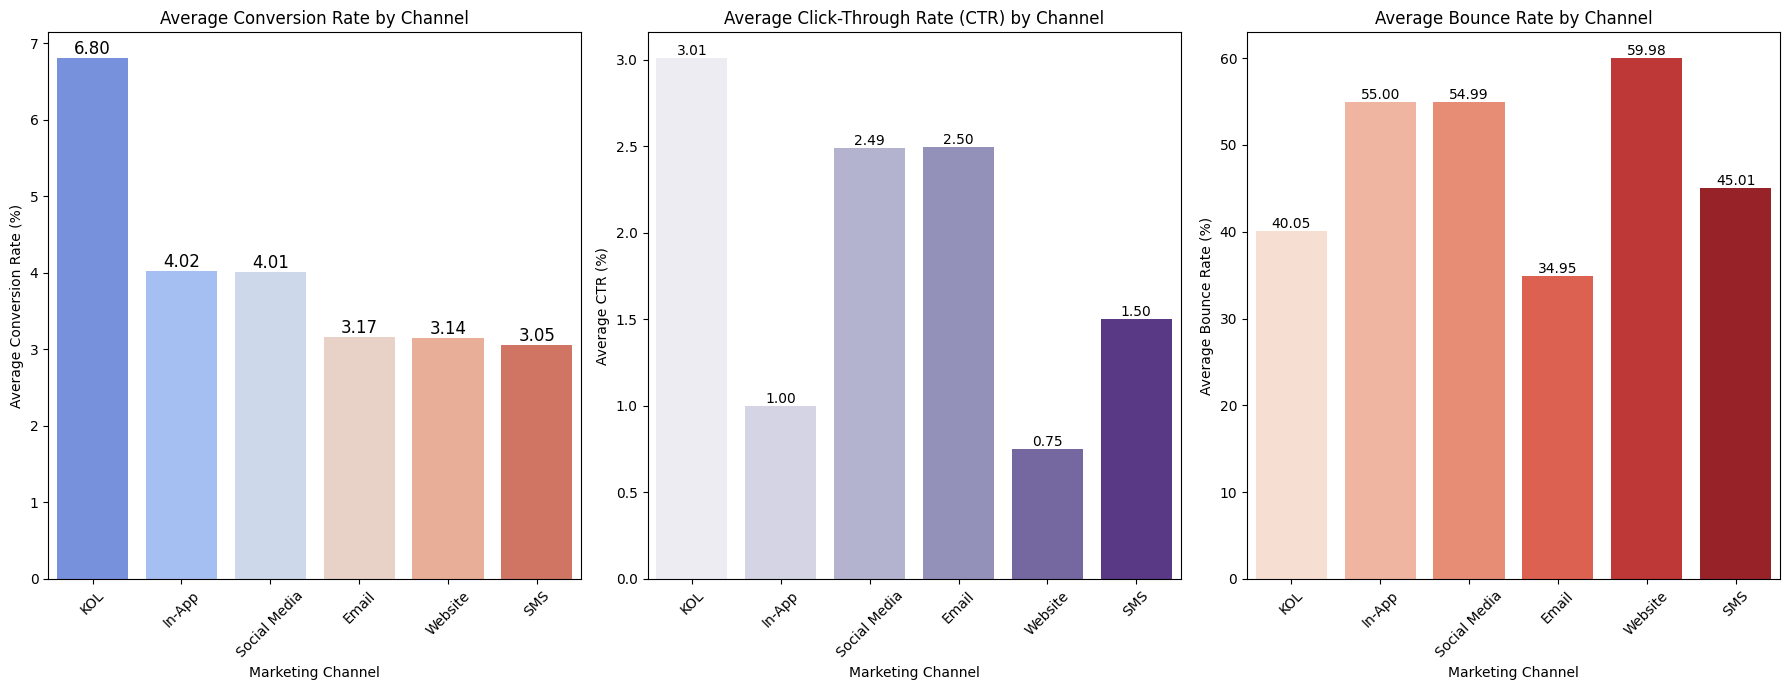

In [ ]:
# Plot Conversion Rate, CTR, and Bounce Rate by Channel
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Conversion Rate
sns.barplot(data=engagement_results, x='channel_name', y='avg_conversion_rate', ax=axes[0], palette='coolwarm', hue = 'channel_name')
axes[0].set_title("Average Conversion Rate by Channel")
axes[0].set_xlabel("Marketing Channel")
axes[0].set_ylabel("Average Conversion Rate (%)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(False)

# Adding value labels for Conversion Rate
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=12)

# CTR
sns.barplot(data=engagement_results, x='channel_name', y='avg_ctr', ax=axes[1], palette='Purples', hue = 'channel_name')
axes[1].set_title("Average Click-Through Rate (CTR) by Channel")
axes[1].set_xlabel("Marketing Channel")
axes[1].set_ylabel("Average CTR (%)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(False)

# Adding value labels for CTR
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

# Bounce Rate
sns.barplot(data=engagement_results, x='channel_name', y='avg_bounce_rate', ax=axes[2], palette='Reds', hue = 'channel_name')
axes[2].set_title("Average Bounce Rate by Channel")
axes[2].set_xlabel("Marketing Channel")
axes[2].set_ylabel("Average Bounce Rate (%)")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(False)

# Adding value labels for Bounce Rate
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Insights from visualizations

**Average Conversion Rate by Channel**

1. KOL, In-App and Social Media has the highest Average Conversion Rates of 6.8% followed by 4%. These channels are most effective in turning visitors into sales. Cost per visitor of those channels are also relatively low.


**Average Click-Through Rate (CTR) by Channel**

1. KOL has the highest CTR (3%), followed by Email and Social Media (5%). This indicates that these channels are most effective in engaging consumers with the content shared through the channel.

2. Website (0.75%) and In-App (1%) have relatively lower CTR. Indicating that the content shared through these channels are less successful in attracting the attention of Shopee's potential customers.

**Average Bounce Rate by Channel**
1. Email (35%) has the lowest bounce rate, followed by KOL (40%) and SMS (45%), indicating that visitors who arrive via these channel are more likely to engage with the content and navigate further, contributing to a higher conversion rate. From this we can infer that Email is generally a more targeted form of marketing that shows customers ads that suit their interest.

2. High bounce rates for Website (60%) and In-App and Social Media (around 55%) suggest that visitors may not find the landing pages relevant or engaging enough, leading to immediate exits. We can infer that these channels are less targeted towards customers which often lead to only quick engagements with the content before exiting.


**Overall insights for engagement metrics**

KOL marketing is shown to be one of the better channels in engaging customers and converting them to sales for Shopee.

Marketing channels such as Email have been useful in engaging customers to view and engage with the marketing content, but less effective in converting these customers to sales.

## 2c : Evaluating Total Revenue over time

In [ ]:
# Extract month and year for grouping
marketing_df['month'] = marketing_df['date'].dt.to_period('M')
revenue_by_channel = marketing_df.groupby(['month', 'channel_name'])['total_revenue'].sum().reset_index()

# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = revenue_by_channel.pivot(index='month', columns='channel_name', values='total_revenue')

print(heatmap_data)

channel_name      Email      In-App         KOL        SMS  Social Media  \
month                                                                      
2019-01       249671.83   825171.00   683108.22  103863.00     959547.72   
2019-02       231637.72   772937.90   613188.96   96578.81     915470.48   
2019-03       174046.41   564352.47   532003.20   69546.34     708137.19   
2019-04       250228.46   824649.60   696119.50   97455.88     972169.64   
2019-05       240134.53   847368.06   650514.72   99572.33    1004255.06   
2019-06       310980.63  1064810.70   886082.97  121696.38    1303187.91   
2019-07       165945.85   584527.62   426417.44   67242.06     700211.85   
2019-08       323910.06  1102382.96   971075.98  130255.29    1277149.81   
2019-09       174094.71   576482.84   434258.30   67960.75     639611.26   
2019-10       321883.24  1082815.23   932734.98  131857.45    1267253.66   
2019-11       434788.28  1703511.80  6911062.78   94594.13    3259378.96   
2019-12     

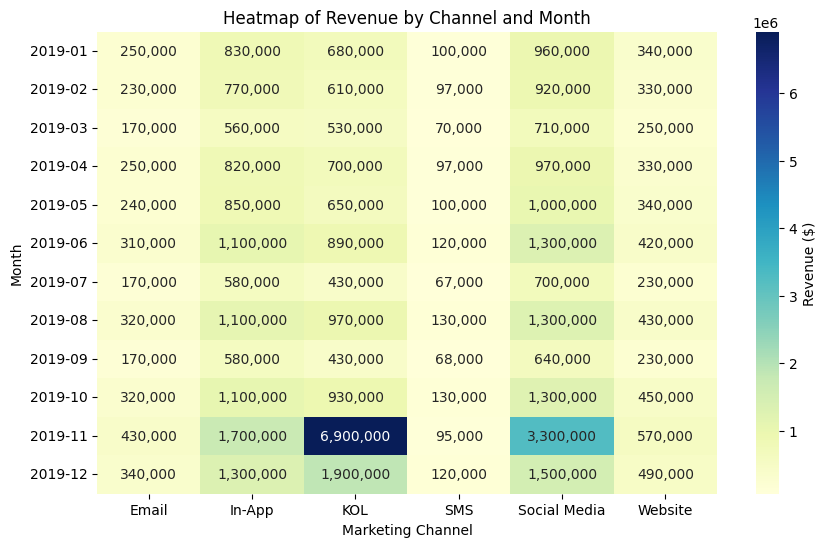

In [ ]:
plt.figure(figsize=(10, 6))
plot = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Revenue ($)'})

# Customizing the annotations to remove scientific notation and format with commas
for text in plot.texts:
    value = float(text.get_text())
    text.set_text(f"{value:,.0f}")

plt.title('Heatmap of Revenue by Channel and Month')
plt.xlabel('Marketing Channel')
plt.ylabel('Month')
plt.show()

## Insights from visualizations

1. A spike in revenue is observed for KOL and Social Media in November. This suggests a highly successful marketing campaigns likely inovlving KOL Referrals, Livestreams and Social Media ads.

2. In-App, KOL and Social Media: These channels consistently generate higher revenue, indicating their profitability in engaging customers.

3. Email, SMS and Website are lagging behind in terms of contribution to overall revenue.

**Seasonal patterns**
* The End-of-Year season generated the highest revenue across multiple channels, esepcially so in Novemeber, likely due to the Shopee's mega 11.11 sales.


## 2d : Evaluating ROI & Overall Comparative Analysis

In [ ]:
roi_results_sorted = roi_results.sort_values(by='ROI', ascending=False)

# Create the funnel chart
fig = px.funnel(roi_results_sorted, x='ROI', y='channel_name', color='channel_name',
                title="ROI by Marketing Channel",
                labels={'ROI': 'ROI (%)', 'channel_name': 'Marketing Channel'})

fig.update_layout(yaxis_title="Marketing Channel", xaxis_title="ROI (%)")
fig.show()

# Overall interpretation of results to evaluate ROI

1. KOL (Key Opinion Leaders) has the highest ROI, exceeding 280%. This suggests that influencer marketing is the most effective in driving sales.

      *   KOL is also one of the most cost effective channels with high Click-Through Rate and high Conversion Rates

      *   Shopee works with KOL (e.g. Livestreamers and brand ambasadors) that has proven to effectively promote brand awareness and sales. This suggests the success of Shopee's Affiliate Marketing Solutions (AMS) which helps sellers expand their brand presence by connecting them with KOLs and other affiliate networks that provide content that drives high engagement which successfully converts visitors to sales.

2. Social Media also has a high ROI, exceeding 220%. This suggests that investments in social media campaigns yield substantial returns.

      *   Social Media is also the most cost effective channel and has a relatively high CTR compared to other channels.

      *   Shopee uses a wide variety of Social Media Marketing techniques on Social Media platforms such as Instagram, FaceBook and TikTok, with catchy jingles that proves to effectively draw in customers and sales, and these have proven to be effective in generating high number of sales.


3. In-App marketing also holds a strong ROI but is lower than Social Media and KOL. This indicates some effectiveness but may need further optimization.

      *   In-App marketing sits on the average in terms of cost-effectiveness.


4. SMS, Email, and Website show considerably lower ROIs (below 50%). This suggests that these channels are not as effective at generating revenue compared to the others. However, Email marketing has shown its potential in engaging customers with its content, hence Shopee can look towards further optimizing Email marketing to generate more leads.



---


**Marketing channels with the top ROI**

Investment in KOL and Social Media marketing channels are well-spent.


*   The higher than industry average for Cost per Sale as a percentage of Average Order Value is justified by the high number of sales generated from the marketing channel, in turn leading to higher ROI.

Recommendations

*   Shopee can allocate even more marketing budgets to these marketing channels to further boost sales and maximuse returns, such as through expanding advertisements to more Social Media platforms and reaching out to KOL's with an even wider reach under Shopee's AMS.


**Marketing channels with average ROI**

In-App marketing has the third highest ROI, but lacking in terms of engagement metrics.



*   In this case, Shopee should re-target current In-App marketing strategies while maintaining, or even better, reducing channel expediture. Further data on Shopee's In-App marketing strategies are required to provide a concrete recommendation, but one possible re-targeting strategy could be to focus more on engaging In-App ads instead of interactive games.


---



**Need for Optimization**

The lower ROI channels (Email, SMS, Website) might require a re-evaluation of their strategies such as :

*   Further improve the targeting and segmentation of Email campaigns through anayzing customer search and purchase history, and extend similar ways of marketing to SMS marketing as well.
*   Reviewing the content and offers in SMS promotions, and increase the reliability of the messages.
*   Increase the reach of Email marketing since it has proven its potential in engaging potential customers.

# **Question 2 : Analyse the impact of various Promotional campaigns on sales**

# Aims of the different campaigns:


1.  **Mega Campaigns (Eg. 9.9 Super Shopping Day, 10.10 Brands Festival, 11.11 Big Sale)**

  *  Increase sales: Create massive awareness and boost sales at a large scale within a short period of time.

  *  Attract new customers through
      - Significant discounts and exclusive deals
      - Catchy jingles that usually go viral on social media platforms

  * Clear inventory: Many sellers use mega campaigns to sell off old inventory or slower-moving products at reduced prices.

2. **Flash Sales**

  *  Increase sales and Conversion Rates: Create urgency and increase conversion as Flash sales only occur for a limited time.

  *  Increase traffic and engagement (Click-Through Rate): Frequent flash sales can drive users back to the app or website regularly, increasing the overall traffic to the platform.

3. **Next Day Delivery**

  *  Improve Customer Retention Rates: Enhance customer satisfaction by meeting the growing demand for fast and reliable shipping services.

4. **Bundle Promotions**

  *  Increase Average Order Value (AOV): Bundling increases the total amount spent by a customer per order, which could contribute to higher revenue.

  * Improve Customer Retention Rate: Improve customer satisfaction by enhance the customers' perception of a good deal, leading to higher satisfaction and potentially repeat purchases.

5. **Livestream Exclusive**

  *  Increase sales: Limited-time offers or special discounts during live streams often lead to impulse purchases.

  * Increase Conversion Rates and Customer Retention Rates : Livestreams allow sellers to showcase product quality and features in real-time, which helps in building consumer trust.

  * Increase sales: Consumers are more likely to discover new products through livestreams, especially when KOLs provide live reviews or endorsements.

6. **Seasonal Sales**

  * Increase sales: During special seasons, consumers are more inclined to spend, making these sales a perfect opportunity to boost revenues.
  
  * Increase AOV: Seasonal sales also encourage consumers to make more purchases in bulk.


In [58]:
#conn = sqlite3.connect(':memory:')
conn = sqlite3.connect('campaign_analysis.db')
# cursor = conn, cursor()
# Write DataFrames to SQL tables
sales_df.to_sql('sales', conn, index=False, if_exists='replace')
campaign_df.to_sql('campaigns', conn, index=False, if_exists='replace')

100000

# Step 1 : Use SQL to query on AOV

## What is Average Order Value (AOV)?

AOV is a critical metric for Shopee Singapore as it reflects the typical spending per transaction and plays a crucial role in revenue optimisation. By increasing AOV through methods like target promotions and product bundling, Shopee can enhance profitability without incurring additional customer acquisition costs.

- AOV provides valuable insights into customer spending behaviour, allowing for more effective segmentation and personalised marketing strategies.

- Additionally, AOV serves as a key performance indicator for evaluating the effectiveness of marketing campaigns, guiding budget allocation to the most profitable channels.


In [59]:
# AOV of each campaign
query_aov = """
WITH campaign_sales AS (
    SELECT
        s.order_id,
        s.customer_id,
        c.campaign_id,
        c.campaign_type AS campaign,
        c.marketing_channel,
        s.price,
        s.discount,
        s.order_time
    FROM
        sales s
    JOIN
        campaigns c ON s.session_id = c.session_id
    WHERE
        s.is_campaign = 1
        AND s.order_time BETWEEN c.start_date AND c.end_date
),

campaign_summary AS (
    SELECT
        campaign,
        marketing_channel,
        COUNT(DISTINCT order_id) AS total_orders,
        SUM(price) AS total_sales,
        (SUM(price) / COUNT(DISTINCT order_id)) AS average_order_value,
        AVG(discount) AS average_discount,
        COUNT(DISTINCT customer_id) AS unique_customers
    FROM
        campaign_sales
    GROUP BY
        campaign
)

SELECT
    campaign,
    marketing_channel,
    total_orders,
    total_sales,
    average_order_value,
    average_discount,
    unique_customers

FROM
    campaign_summary
ORDER BY
    campaign;
"""

aov_result_df = pd.read_sql_query(query_aov, conn)
print(aov_result_df)

               campaign marketing_channel  total_orders   total_sales  \
0     Bundle promotions           Website            77   3494.285590   
1            Flash Sale      Social Media            80   1607.817064   
2  Livestream Exclusive      Social Media           140   7723.428771   
3            Mega Sales           Website          2366  97138.690450   
4     Next Day Delivery      Social Media           143   5585.164955   
5        Seasonal Sales            In-App           192   4945.792512   

   average_order_value  average_discount  unique_customers  
0            45.380332         22.766234                74  
1            20.097713         16.150000                79  
2            55.167348         36.728571               137  
3            41.056082         12.539730              1495  
4            39.057098          8.972028               137  
5            25.759336         21.161458               186  


# Step 2 : Analysis of data and relevant visualizations

## 2a : Total sales, AOV and unique customers by campaign type

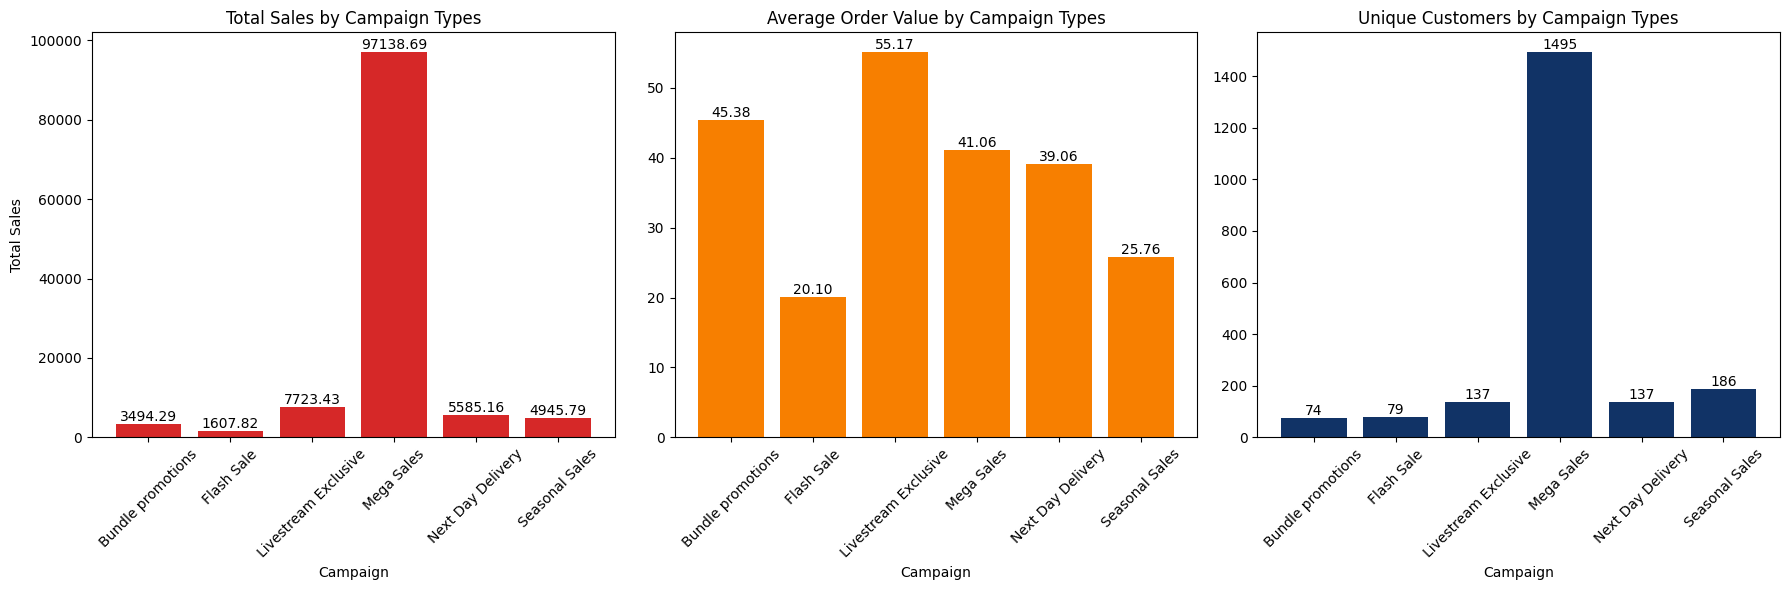

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot 1: Total Sales by Campaign
bars1 = axes[0].bar(aov_result_df['campaign'], aov_result_df['total_sales'], color='#d62828')
axes[0].set_xlabel('Campaign')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('Total Sales by Campaign Types')
axes[0].tick_params(axis='x', rotation=45)

for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')


# Plot 2: Average Order Value by Campaign
bars2 = axes[1].bar(aov_result_df['campaign'], aov_result_df['average_order_value'], color='#f77f00')
axes[1].set_xlabel('Campaign')
axes[1].set_title('Average Order Value by Campaign Types')
axes[1].tick_params(axis='x', rotation=45)

for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')


# Plot 3: Unique Customers by Campaign
bars3 = axes[2].bar(aov_result_df['campaign'], aov_result_df['unique_customers'], color='#113366')
axes[2].set_xlabel('Campaign')
axes[2].set_title('Unique Customers by Campaign Types')
axes[2].tick_params(axis='x', rotation=45)

for bar in bars3:
    yval = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Adjust layout and spacing
plt.tight_layout()
plt.show()

## Insights from visualisations:



1.  Total Sales by Campaign Types


  *    Mega Sales significantly outperformed all other campaigns,
  with an extremely high total sales (`$97,138.69`) compared to other campaigns. Flash sale, however, has the lowest sales (`$1,607.82`).



2.  Average Order Value by Campaign Types


*   The Bundle Promotions campaign has the highest average order value (AOV) of `55.17`. This indicates that customers purchasing through this campaign tend to spend more per transaction, which is a positive indicator for profitability.

*   The AOV across other campaigns (ranging from about `20.10 to 45.38`) shows relatively healthy spending, but the difference in AOV suggests that different promotional strategies may lead to varying customer spending behaviors.



3.   Unique Customers By Campaign



*   Mega Sales again stands out with `1,495` unique customers, indicating its broad reach and appeal. This suggests that the campaign was successful not only in attracting existing customers but also in acquiring new ones.
*  Other campaigns like Bundle Promotions and Flash Sale attracted significantly fewer unique customers (`74` and `79`, respectively), indicating potential areas for improvement in customer acquisition strategies.

## Overall observations from visualisations:


*   The Mega Sales campaign appears to be the most effective across all metrics, suggesting that strategies used in this campaign could be analyzed and potentially replicated in other campaigns.This also shows how the Mega Sales campaign have best met its promotional campaign aims through increasing sales greatly and attracting much higher unique customers.

*  The high average order value of Livestream Exclusive indicates that customers tend to purchase more or are willing to purchase items with higher prices when they watch livestreams with live demonstrations and honest reviews of the products.

*  Bundle Promotions has the second highest AOV of `45.38` indicates that there may be effective bundle deals or cross-selling strategies in place that could be leveraged further. This also shows how the Bundle promotions campaign have met its promotional campaign aim of increasing AOV.

*   Low unique customer counts in Bundle Promotions and Flash Sales, suggest that there may be opportunities to improve outreach and engagement in these campaigns, so as to boost engagement level and eventually boost sales too. This shows that these campaigns could be improved to better meet its promotional campaign's aims.















## 2b : Evaluate total sales of each campaign by category

In [61]:
# Find each category metrics for each campaign
category_query = """
WITH indiv_category AS (
  SELECT
      s.order_id,
      s.customer_id,
      s.main_category AS category,
      c.campaign_id,
      c.campaign_type AS campaign,
      c.target_audience,
      s.price,
      s.discount,
      s.order_time
  FROM
      sales s
  JOIN
      campaigns c on s.session_id = c.session_id
  WHERE
      s.is_campaign = 1
      AND s.order_time BETWEEN c.start_date AND c.end_date
)

,category_summary AS(
  SELECT
      campaign,
      category,
      COUNT(DISTINCT order_id) AS total_orders,
      SUM(price) AS total_sales,
      COUNT(DISTINCT customer_id) AS unique_customers,
      (SUM(price) / COUNT(DISTINCT order_id)) AS AOV

  FROM indiv_category
  GROUP BY campaign, category
)

,aov_campaign AS(
  SELECT
    campaign,
    unique_customers,
    total_orders,
    total_sales,
    AOV
  FROM category_summary
  ORDER BY AOV DESC
)

SELECT
    campaign,
    category,
    unique_customers,
    total_orders,
    total_sales,
    AOV
FROM category_summary
ORDER BY campaign;
"""

category_result = pd.read_sql_query(category_query, conn)
print(category_result)

             campaign          category  unique_customers  total_orders  \
0   Bundle promotions        Automotive                 1             1   
1   Bundle promotions       Baby & Toys                 1             1   
2   Bundle promotions  Groceries & Pets                 1             1   
3   Bundle promotions   Health & Beauty                16            16   
4   Bundle promotions     Home & Living                 6             6   
..                ...               ...               ...           ...   
85     Seasonal Sales  Sports & Outdoor                 3             3   
86     Seasonal Sales           Watches                 2             2   
87     Seasonal Sales     Women Clothes                32            32   
88     Seasonal Sales       Women Shoes                 2             2   
89     Seasonal Sales      Women's Bags                 1             1   

    total_sales        AOV  
0     74.116057  74.116057  
1      8.682167   8.682167  
2      3.394

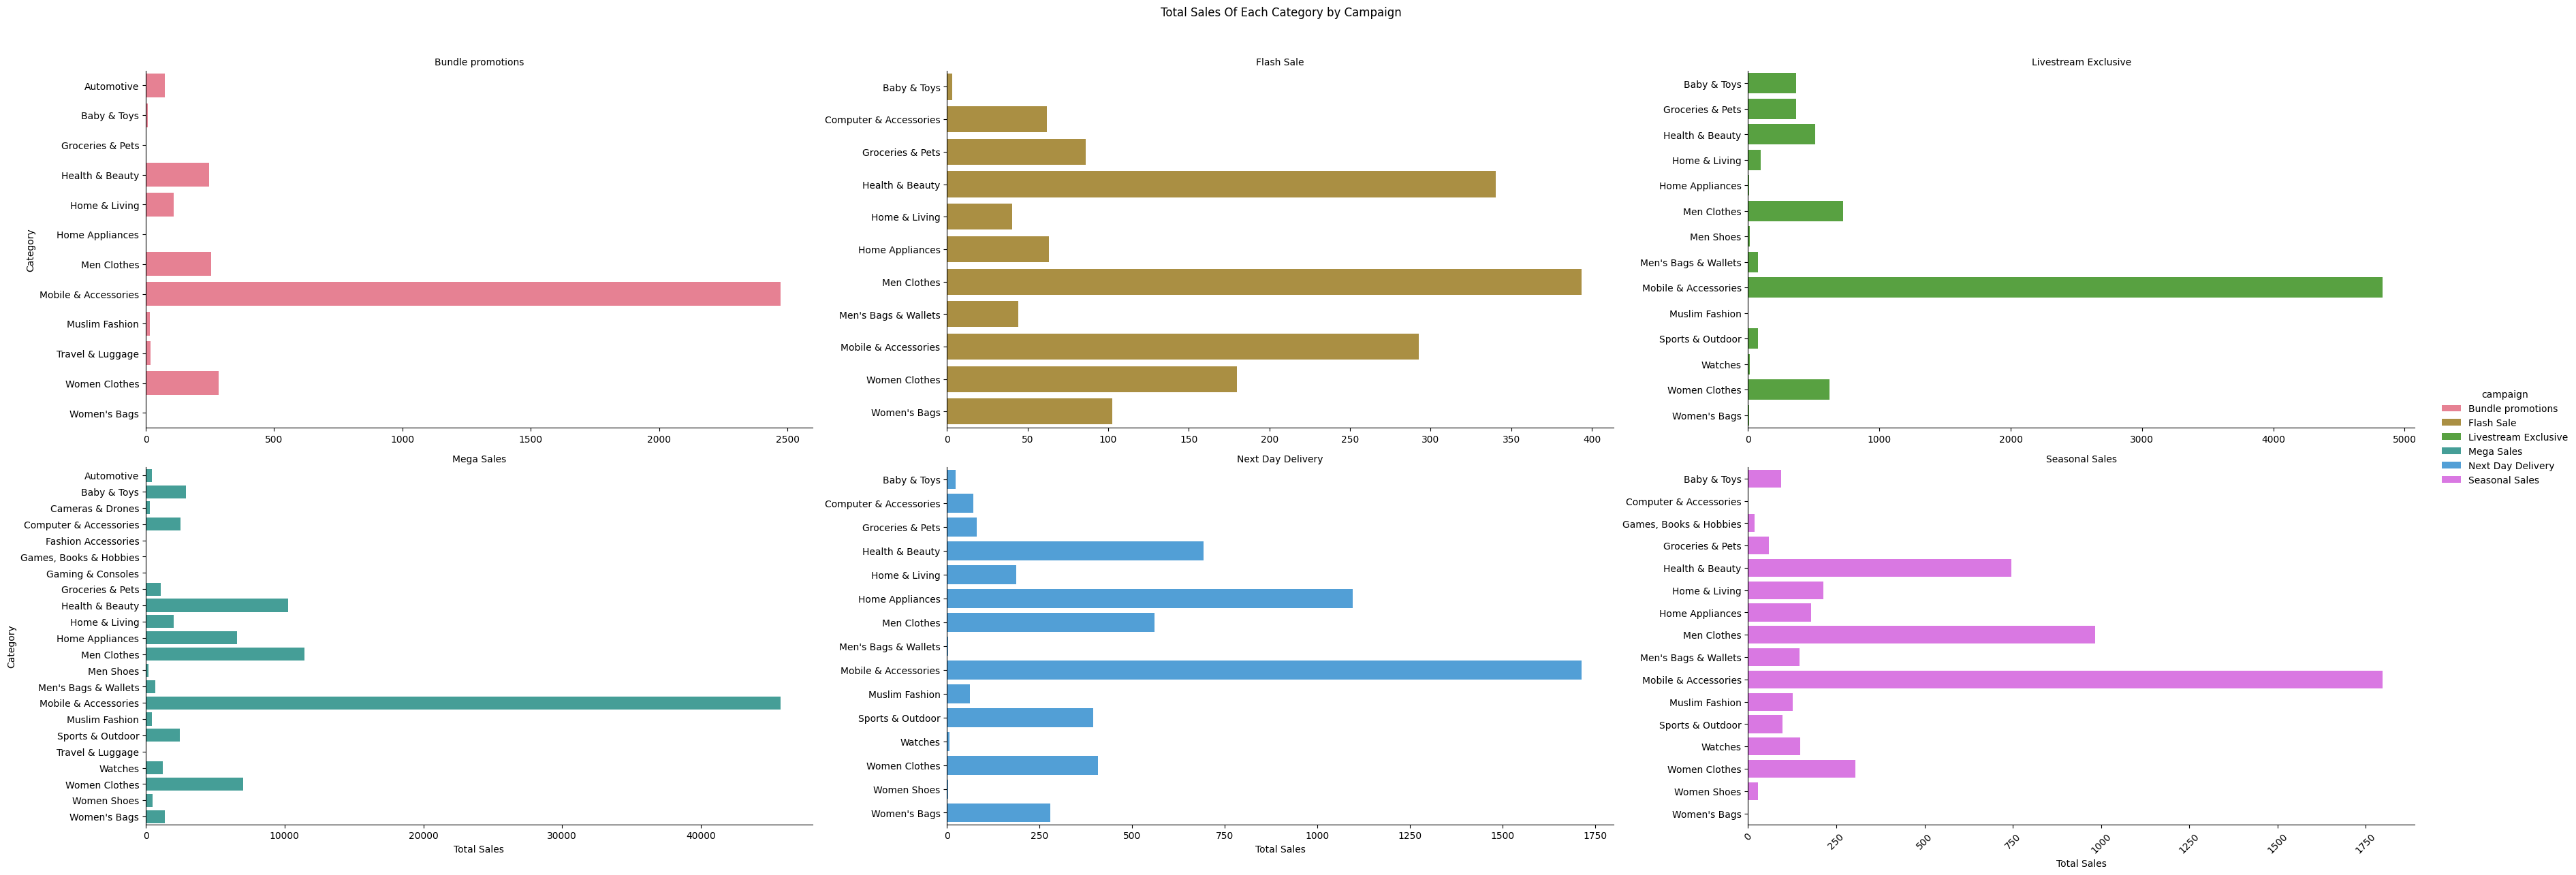

In [62]:
category_result_melted = pd.melt(category_result, id_vars=['campaign', 'category'],
                                   value_vars=['total_sales'],
                                   var_name='metric', value_name='value')

unique_campaign = category_result['campaign'].unique()
palette = sns.color_palette("husl", len(unique_campaign))  # Use "husl" for distinct colors
color_map = dict(zip(unique_campaign, palette))

g = sns.catplot(data=category_result_melted, x='value', y='category', hue='campaign',
                kind='bar', height=6, aspect=2, palette=color_map, col='campaign',
                col_wrap=3, sharex=False, sharey=False)

g.fig.suptitle('Total Sales Of Each Category by Campaign', y=1.05)
g.set_axis_labels('Total Sales', 'Category')
g.set_titles("{col_name}")


plt.xticks(rotation=45)
plt.show()

## Insights from visualisations:



1.  Mega Sales

*    The Mega Sales campaign has the highest total sales across multiple categories, particularly in Mobile & Accessories, Men Clothes and Health & Beauty, indicating a strong performance in these product categories. This suggests that products under these categories resonate well with customers during significant promotional events like the Shopee Mega Sales.

*   Categories like Home Appliances and Women Clothes also show noteworthy sales, highlighting their appeal during the Mega Sales.

2.  Bundle Promotions & Seasonal Sales

*  Both Bundle Promotions and Seasonal Sales perform well in categories like Mobile & Accessories and Men Clothes, though its total sales are generally lower compared to the Mega Sales.


3.   Flash Sale

*  Flash Sale has a relatively high sales for Mobile & Accessories and Groceries & Pets categories.

4.   Livestream Exclusive

*  Livestream Exclusive performs paticularly well in Mobile & Accessories. Other cateogories such as both Men and Women Clothes and Health & Beauty performed relatively well too. This suggests that having exclusive livestream deals on products under these categories could potentially drive sales by attracting a targeted audience interested in real-time demonstrations and exclusive offers.

5.   Next Day Delivery

*  Products under Mobile & Accessories, Home Appliances and Health & Beauty categories are rather popular for the Next Day Delivery Campaign.  This trend indicates that customers highly value convenience and quick fulfillment for essential and frequenly used items.


## Overall observations from visualisations:


*  Overall, Mobile & Accessories, Health & Beauty and Men Clothes are consistently high-performing categories across various campaigns. The popularity of these categories may reflect evolving customer behaviour, where customers are increasingly inclined to invest in technology, personal care products, and fashion items.













**Overall findings for AOV of each campaign type**


*   Among the six campaigns analysed, Livestream Exclusive stands out with the highest AOV of `55.17`, indicating that getting KOL to promote products on campaign day is useful as people tend to purchase more when watching KOL livestreams.

*   Additionally, Bundled Promotions stand out with the second highest AOV of `45.38`, indicating that there is strong customer interest in purchasing multiple items together. This suggests that offering bundles may effectively encourage larger transactions. The 'Mobile & Accessories' category, with total sales of `$2,473.14`, underscores the importance of this segment in driving revenue when there are bundled promotions.


*   The Mega Sales event recorded a total of `2,366` orders and generated `$97,138.69` in sales, resulting in an AOV of `41.06`. While this is lower than the other campaigns, the substantial volume of orders reflects strong consumer engagement during this period. Categories like 'Mobile & Accessories,' 'Men's Clothes,' and 'Health & Beauty' were pivotal in achieving these sales figures. This also shows that customers are attracted to the deep discount provided on Mega Sales, so there are more orders but AOV is not the highest.



*   Flash Sale has the lowest AOV at `20.10`, with Men Clothes having the highest total sales at `$292.48`.











**Recommendations**



1.  Seasonal Themed Campaigns



*   Electronics Day
    *   Given the consistent performance of Mobile & Accessories across multiple
campaigns, Shopee should consider increasing the frequency of Electronics Days on non-campaign days. This would allow for exclusive deals and discounts on electronic products, enticing tech-savvy customers and driving additional sales during regular shopping periods.

    *   With bundled promotions yielding the highest AOV, Shopee can strategically pair bundled promotions with the Electronics Days. Special bundle offers on electronic devices can attract customers looking for value while simultaneously boosting the average transaction size. For example, offering discounts on accessory bundles when purchasing a smartphone or laptop can encourage larger purchases.

*   Fashion Day

    *   With livestream exclusive yielding the highest AOV, Shopee can get KOL to livestream on Fashion Day. They can promote apparels and fashion accessories by trying them on. KOLs can also provide detailed descriptions of the products, focusing on aspects like sizing, material quality, and styling tips. These visual demonstrations allow customers to see how the items fit. KOLs can share their genuine opinions about the products. Honest reviews help build trust and authenticity, which can be pivotal in converting viewers into buyers.

     *   Livestreaming also encourage viewers to ask questions in real-time, creating a dialogue between the KOL and the audience. Such interaction may lead to higher engagement and conversion rates.

*   Beauty Day

    *   By offering discounts and special promotions, Beauty Day encourages buyers to shop for beauty products, helping sellers to boost sales for items under this category.

    *   Use Beauty Day to attract shoppers interested in beauty and personal care products, ensuring that they get access to special deals and exclusive bundles. This can help sellers and Shopee to retain customers, foster repeat purchases and build loyalty over time.


2.  Continue to boost sales and orders on Mega Sales

* To continue achieving the objectives of Mega Sales, primarily aimed at increasing overall sales and attracting new customers, Shopee should consider enhancing incentives for sellers to invest more in Shopee ads. This strategy would increase the visibility of their products by featuring them prominently on the homepage banner and ensuring their shops appear in search results for relevant items.


*   Additionally, encouraging more sellers to participate in whole-shop deep discount promotions, particularly on Mega Sales days, could significantly drive traffic to their stores. By offering attractive deals across a wide range of products instead of limiting discounts to just a few items, Shopee can create a compelling shopping experience that attracts a larger customer base.


*   Introduce incentives for sellers who consistently achieve high sales and customer satisfaction (eg. lower commision fees, ad credits or exclusive promotional opportunities). This could motivate sellers to enhance their product quality and customer service.

3.   Enhance the Livestream Shopping Experience


*   Make the livestream shopping experience more interactive by including elements like real-time Q&A, live polling, and instant purchasing options within the livestream. This fosters engagement and motivates viewers to make impulse purchases.

*   Consider running contests or giveaways during the livestream to incentivize participation and sharing, expanding the reach of the campaign.






## 2c : Breakdown of AOV by campaign and marketing channel



In [63]:
# AOV of each campaign split into respective marketing channels
query = """
WITH campaign_sales AS (
    SELECT
        s.order_id,
        s.customer_id,
        c.campaign_id,
        c.campaign_type AS campaign,
        c.marketing_channel,
        c.target_audience,
        s.price,
        s.discount,
        s.order_time
    FROM
        sales s
    JOIN
        campaigns c ON s.session_id = c.session_id
    WHERE
        s.is_campaign = 1
        AND s.order_time BETWEEN c.start_date AND c.end_date
),

campaign_summary AS (
    SELECT
        campaign,
        marketing_channel,
        target_audience,
        COUNT(DISTINCT order_id) AS total_orders,
        SUM(price) AS total_sales,
        (SUM(price) / COUNT(DISTINCT order_id)) AS average_order_value,
        AVG(discount) AS average_discount,
        COUNT(DISTINCT customer_id) AS unique_customers,
        COUNT(DISTINCT CASE WHEN target_audience = 'new customer' THEN customer_id END) AS new_customers,
        COUNT(DISTINCT CASE WHEN target_audience = 'returning customer' THEN customer_id END) AS returning_customers
    FROM
        campaign_sales
    GROUP BY
        campaign, marketing_channel, target_audience
)

SELECT
    campaign,
    marketing_channel,
    target_audience,
    total_orders,
    total_sales,
    average_order_value,
    average_discount,
    unique_customers,
    new_customers,
    returning_customers

FROM
    campaign_summary
ORDER BY
    campaign, marketing_channel, target_audience;
"""

result_df = pd.read_sql_query(query, conn)
result_df.to_csv('shopee_sales_result.csv', index=False)
print(result_df)

             campaign marketing_channel     target_audience  total_orders  \
0   Bundle promotions             Email  returning customer             1   
1   Bundle promotions            In-App        new customer             4   
2   Bundle promotions            In-App  returning customer            35   
3   Bundle promotions               KOL        new customer             2   
4   Bundle promotions               KOL  returning customer            13   
..                ...               ...                 ...           ...   
62     Seasonal Sales               SMS  returning customer             1   
63     Seasonal Sales      Social Media        new customer            12   
64     Seasonal Sales      Social Media  returning customer            48   
65     Seasonal Sales           Website        new customer             3   
66     Seasonal Sales           Website  returning customer             7   

    total_sales  average_order_value  average_discount  unique_customers  \

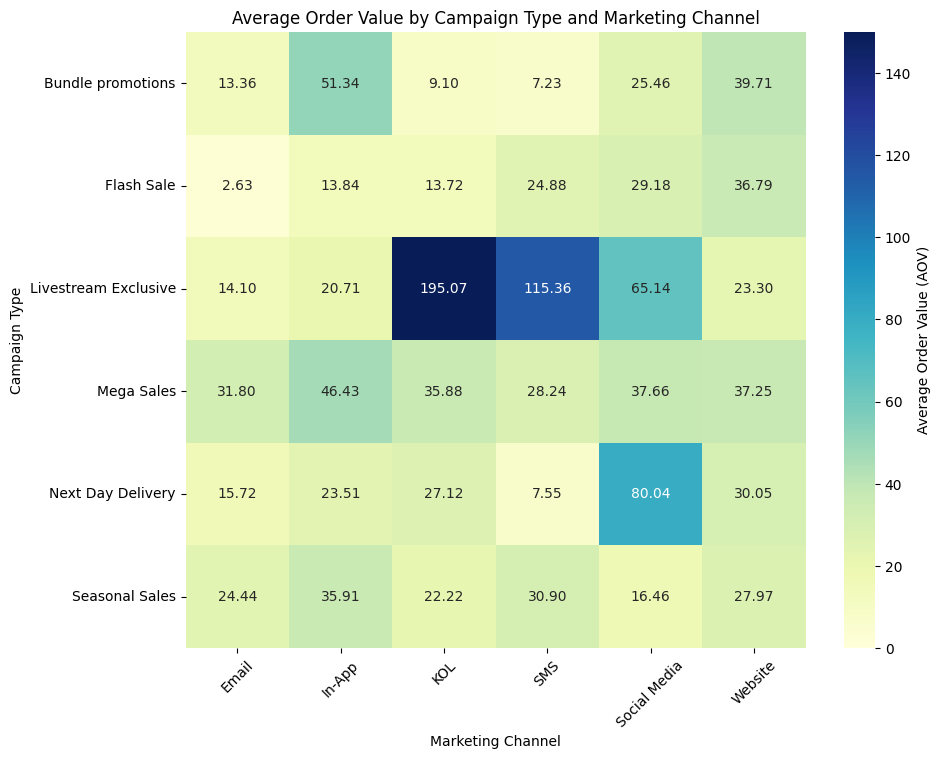

In [64]:
np.random.seed(42)
heatmap_data = result_df.pivot_table(values='average_order_value',
                                                  index='campaign',
                                                  columns='marketing_channel',
                                                  aggfunc='mean')

# Plotting the heatmap
vmin = 0  # Minimum AOV
vmax = 150  # Maximum AOV

# Plotting the heatmap with specified color range
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",
            cbar_kws={'label': 'Average Order Value (AOV)'}, vmin=vmin, vmax=vmax)
plt.title('Average Order Value by Campaign Type and Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Campaign Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Insights from visualisations:



1.  Mega Sales

*    Mega Sales have a moderate AOV ranging from `$28.24 to $46.43`. As the AOV for all marketing channels are in a similar range, it suggests that large promotional events like Mega Sales are effectively marketed across the different channels. The moderate AOV during Mega Sales may also be due to high volume of low-value transactions as Mega Sales is the biggest campaign in Shopee which yields the highest total sales, and many products are sold at deep discount prices.

*    Affordable products such as small electronics, fashion items or daily essentials with lower AOVs may be heavily featured on Mega Sales, causing many customers to focus purchasing budget-friendly items during Mega Sales.


2.  Bundle Promotions

*  In-App marketing is doing much better than the other marketing channels for Bundle Promotions with AOV of `51.34`. This indicates that In-App marketing is particularly effective at driving high-value orders for Bundle Promotions. On the other hand, SMS (AOV of `14.44`) and KOL (AOV of `9.10`) did not do so well.


3.   Flash Sale

*  Flash Sales have a moderate AOV ranging from `13.72 to 36.79`. However, Email is an exception with an extremely low AOV of `2.63`. Flash Sales are designed to create urgency and encourage quick purchases. This can lead to a focus on low-cost items that customers feel they can buy impulsively rather than on higher-value purchases. The extremely low AOV for Email may indicate that audience engaging with email promotions may not be the same as those engaging with Flash Sales through other marketing channels.

4.   Livestream Exclusive

*  Livestream Exclusive has an extremely high AOV of `195.07` from KOL marketing. SMS also have a rather high AOV of `115.36`. This suggests that customers are willing to spend significantly more when engaging with livestream content, especially when it is facilitated by trusted KOLs.

5.   Seasonal Sales

*  Seasonal sales show decent AOVs throughout all marketing channels. In general, its AOV across all marketing channels are rather low compared to other campaign types.

6.   Next Day Delivery

*  AOV for social media is the highest at `80.04`, while SMS has the lowest AOV of `7.55`,  reveals important insights into customer behavior, engagement strategies, and the effectiveness of various marketing channels. This may be because Social media platforms are inherently interactive, allowing brands to engage customers in a dynamic manner. Users often interact with content, such as comments, shares, and likes, fostering a sense of community and trust around the products being promoted. This engagement can translate into a willingness to spend more per transaction.

*  Conversely, SMS is a more direct and personal communication channel, often limited to short messages. This format can restrict the depth of information conveyed, leading to less engagement.



## Overall observations from visualisation:

*  Overall, the effectiveness of a marketing channel may vary depending on the campaign type. For example, KOL marketing show exceptional performance in Livestream Exclusive, while In-App and Social Media excel during Bundle Promotions and Mega Sales. This highlights the importance of aligning the right campaign type with the most effective marketing channels.

*  Some campaign types, like Mega Sales and Seasonal Sales, show relatively consistent AOVs across channels, indicating effective marketing strategies. In contrast, others exhibit more variability, suggesting that certain channels may not be as well-suited for particular campaigns.



**Recommendations**



1.  Increase Focus on High-Performing Channels


*   Increase investment on KOL marketing for Livestream Exclusive
    *   Since KOL marketing shows exceptional AOV for Livestream Exclusive, Shopee should not only increase investment in this area but also explore partnerships with diverse KOLs to reach various audience segments. Consider experimenting with different types of marketing content, such as tutorials, unboxing videos, or giveaways.


*   Increase investment on In-App and Social Media for Mega Sales and Bundle Promotions
    *   Given the relatively high AOV associated with In-App and Social Media for Mega Sales and Bundle Promotions, Shopee should enhance their marketing strategies for these channels.

    *   Utilise customer data to segment audiences based on purchasing behaviour, demographics, and interests. Tailor advertisements to resonate with specific segments, promoting products likely to appeal to them.

    *   Implement retargeting ads on social media and in-app notifications for users who have previously engaged with Mega Sales or Bundle Promotions, reminding them of items they viewed or added to their cart.


2.  Review Next Day Delivery Marketing Performance

* Next Day Delivery is generally viewed as a standard service rather than a major promotional campaign, which may limit the effectiveness of its marketing efforts. As a result, Shopee can consider to pair Next Day Delivery with ongoing promotions or campaigns to increase its perceived value. For example, offer free Next Day Delivery on orders over a certain amount during promotional periods.

* Additionally, Shopee can use customer data to segment audiences and tailor marketing messages for those who frequently shop last minute or tend to spend more. Personalised messaging can enhance relevance and drive higher engagement.











---



# **Conclusion**

The above analyses of Shopee Singapore's marketing channels and campaigns highlights that KOL and Social Media marketing are the most effective strategies with the highest ROI, and Mega Sales with the highest total sales. Given these strengths, Shopee should consider increasing investment in these areas and refining advertisement strategies to capitalise on their success.

Considerations:


*    Collaborate with more influential KOLs and produce engaging, high-quality content to enhance brand visibility and customer engagement.

*   Use data analytics to gain insights into customer preferences and behaviors and tailor campaigns to address specific audience segments effectively.  

*   Implement A/B testing for ads to determine which creatives, messages, and formats yield the best results, especially for Email marketing which shown potential in engaging potential customers.

*  Create interactive content like polls, quizzes, or contests that engage users and to know more about the users to make the marketing and campaign more targeted.

---

Analysing Average Order Value (AOV) across different campaigns provides valuable insights into consumer behaviour and preferences:

*   Livestream Excusive has the highest AOV of `55.17`, indicating the effectiveness and reliability of promoting products through KOLs.

*   Bundle Promotions, with the second highest AOV of `45.38`, demonstrate a strong interest in multi-item purchases, indicating that this strategy effectively encourages larger transactions. The significant sales within the Mobile & Accessories category suggest that Shopee can leverage bundle offerings to enhance overall revenue and customer satisfaction.

*   The Mega Sales event, while yielding a lower AOV of `41.06`, succeeded in generating a high volume of orders, showcasing strong engagement and awareness during significant sales events. This indicates that while AOV is a critical metric, total sales volume during mega campaigns should not be overlooked as a vital contributor to overall revenue.

*   Flash Sale has the lowest AOV at `20.10`. Might need to see if customers are effectively engaged with Flash Sales.

---
# Strategic Implications for ROI and AOV

1.   Shopee should prioritise KOL and Social Media marketing channels, leveraging their high ROI and CTR. Increasing budget allocation to these marketing channels can potentially improve brand engagement and conversion rate, thus impacting sales performance.

2.   Given the findings on AOV, Shopee should optimise promotional strategies for Bundle Promotions and Livestream Exclusive. Tailoring offerings to maximise customer interest in these campaigns can significantly enhance revenue and customer satisfaction.

3.    Implementing strategies that improve customer retention, for campaigns such as Next Day Delivery and Flash Sales. These can potentially enhance overall customer lifetime value, thereby contributing positively to ROI.

4. Channels such as SMS, Website and Email have shown to be less efficient in terms of cost and contribution to ROI, with relatively low AOV across most campaign types. This strongly highlights the need for Shopee to re-evaluate the marketing stratgeies behind these channels and to re-allocate marketing budget spent on these channels to optimize conversions, sales and revenue.  



---



# **Final Thoughts:**

By aligning marketing efforts with consumer preferences and campaign objectives, Shopee Singapore can significantly enhance its overall effectiveness in driving sales and increasing Average Order Value (AOV). The analysis reveals that KOL and social media marketing channels yield the highest ROI, while strategies like Bundle Promotions and Livestream Exclusive demonstrate strong potential for increasing AOV.

Continuous analysis and optimisation of these strategies will be necessary for maintaining competitiveness in the dynamic e-commerce landscape. Shopee should focus on refining its campaigns to better resonate with customers, leveraging data insights to adapt to changing consumer behaviors and preferences.Investing in effective campaigns that resonate with customers will ultimately lead to improved sales performance and customer retention.

In summary, by strategically investing in effective marketing channels and continuously optimizing campaign performance, Shopee Singapore is well-positioned to thrive in the evolving e-commerce market.

# **Note on Limitations**

This analysis was conducted using a synthetically generated dataset created to simulate marketing performance metrics. While efforts were made to closely approximate real-world E-commerce data, we have to recognize several limitations that arise from the nature of synthetic data and the assumptions on which it is based:



1.   Assumptions-based data: The dataset was generated based on predefined assumptions, including average order values, conversion rates, click-through-rates and bounce rates. These assumptions may not accurately reflect real customer behaviors or marketing and campaign dynamics, leading to potential discrepancies between the synthetic data and actual performance metrics.

2.   Lack of real-world variability: The synthetic data may lack the variability and fluctuations present in real-world data. We have attempted to incorporate seasonal trends by defining usual Shopee sale dates and weighted the marketing and campaign data acccordingly. However, factors such as unforeseen market shifts, unique customer interactions, or change in consumer preferences are not fully captured, which can limit the generalizability of the insights.



3.   Potential bias in channel and campaign performance: Assumptions made about each marketing channel's and campaign's effectiveness may introduce biases. For example, since conversion rates and costs were set based on hypothetical performance expectations based on average E-commerce metrics, the relative effectiveness of each channel is skewed, affecting ROI and other comparative metrics.

4. Simplified customer behavior: Synthetic data often may not capture the complexity of real interactions. For instance, brand loyalty, repeat purchases, or cross-channel interactions might not be fully represented, potentially impacting analyses of long-term value or cross-channel synergies.

5. Limitations in predictive validity: Insights derived from synthetic data should be interpreted with caution if applied to forecasting or strategic planning. Since the data does not reflect actual historical patterns of Shopee, any projections or predictions may not hold true under real-world conditions.

Conclusion: We have prepared the synthetic datasets due to lack of public datasets and statistics regarding Shopee's marketing channel and campaign's cost, revenue and performance and engagement metrics. We have used the datasets as a framework for our exploratory analysis to draw analytical insights to address Shopee's business objectives. Future analyses incorporating real performance metrics and historical data are recommended to achieve more accurate and actionable insights.